In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
warnings.filterwarnings('ignore')

In [9]:
def preprocess_and_evaluate_all_models(train, test, submission_template):
    """
    Preprocess data, evaluate multiple models, and generate submission files.

    Parameters:
    - train (pd.DataFrame): Training dataset.
    - test (pd.DataFrame): Test dataset.
    - submission_template (pd.DataFrame): Submission template.

    Returns:
    - results (pd.DataFrame): DataFrame containing results for all models and preprocessing steps.
    """
    from itertools import product
    from sklearn.metrics import mean_absolute_percentage_error
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.compose import ColumnTransformer
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
    from catboost import CatBoostRegressor
    from pytorch_tabnet.tab_model import TabNetRegressor
    from sklearn.linear_model import LinearRegression, Ridge
    from sklearn.ensemble import RandomForestRegressor
    import numpy as np
    import pandas as pd
    
    # Preprocessing configurations
    imputation_strategies = ['mean', None]
    encoding_strategies = ['label', 'onehot']
    scaling_strategies = ['standard', 'minmax']
    log_transform_options = [True, False]

    # Models and their parameter grids
    models = {
        'Linear Regression': (LinearRegression(), None),
        'Ridge': (Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
        'Random Forest': (RandomForestRegressor(random_state=42), {'n_estimators': [50, 100]}),
        'XGBoost': (XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, random_state=42), {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }),
        'LightGBM': (LGBMRegressor(random_state=42, device='gpu'), {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [20, 31, 50],
            'max_depth': [-1, 10, 20]
        }),
        'CatBoost': (CatBoostRegressor(task_type='GPU', random_state=42, verbose=0), {
            'iterations': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'depth': [4, 6, 8]
        }),
        # 'TabNet': (TabNetRegressor(verbose=0), {
        #     'n_d': [8, 16, 32],
        #     'n_a': [8, 16, 32],
        #     'n_steps': [3, 5, 7],
        #     'gamma': [1.2, 1.5, 2.0]
        # })
    }

    # Store results
    results = []

    # Split data
    train, val = train_test_split(train, test_size=0.2, random_state=42)

    # Drop 'id' column
    train = train.drop(columns=['id'])
    val = val.drop(columns=['id'])
    test = test.drop(columns=['id'])

    # Iterate over preprocessing options
    for imputation, encoding, scaling, log_transform in product(imputation_strategies, encoding_strategies, scaling_strategies, log_transform_options):
        print(f"\nPreprocessing: Imputation={imputation}, Encoding={encoding}, Scaling={scaling}, Log_Transform={log_transform}")

        # Copy datasets
        train_copy, val_copy, test_copy = train.copy(), val.copy(), test.copy()

        # Handle missing values
        if imputation == 'mean':
            imputer = SimpleImputer(strategy='mean')
            train_copy['num_sold'] = imputer.fit_transform(train_copy[['num_sold']])
            val_copy['num_sold'] = imputer.transform(val_copy[['num_sold']])
        elif imputation is None:
            train_copy = train_copy.dropna(subset=['num_sold'])
            val_copy = val_copy.dropna(subset=['num_sold'])

        # Log transform target variable
        if log_transform:
            train_copy['num_sold'] = np.log1p(train_copy['num_sold'])
            val_copy['num_sold'] = np.log1p(val_copy['num_sold'])

        # Feature extraction from date
        for df in [train_copy, val_copy, test_copy]:
            df['date'] = pd.to_datetime(df['date'])
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day'] = df['date'].dt.day
            df['weekday'] = df['date'].dt.weekday
            df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
            df.drop(columns=['date'], inplace=True)

        # Separate features and target
        feature_cols = train_copy.columns.difference(['num_sold'])
        X_train, y_train = train_copy[feature_cols], train_copy['num_sold']
        X_val, y_val = val_copy[feature_cols], val_copy['num_sold']
        X_test = test_copy[feature_cols]

        # Encoding categorical variables
        cat_cols = ['country', 'store', 'product']
        if encoding == 'label':
            encoder = LabelEncoder()
            for col in cat_cols:
                X_train[col] = encoder.fit_transform(X_train[col])
                X_val[col] = encoder.transform(X_val[col])
                X_test[col] = encoder.transform(X_test[col])
        elif encoding == 'onehot':
            transformer = ColumnTransformer(
                transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough'
            )
            X_train = pd.DataFrame(transformer.fit_transform(X_train))
            X_val = pd.DataFrame(transformer.transform(X_val))
            X_test = pd.DataFrame(transformer.transform(X_test))

        # Scaling
        if scaling == 'standard':
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)
        elif scaling == 'minmax':
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)

        # Iterate over models
        for model_name, (model, param_grid) in models.items():
            print(f"\nTraining {model_name}...")
            if param_grid:
                random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, scoring='neg_mean_absolute_percentage_error', random_state=42, verbose=1)
                random_search.fit(X_train, y_train)
                best_model = random_search.best_estimator_
            else:
                model.fit(X_train, y_train)
                best_model = model

            # Evaluate
            y_pred = best_model.predict(X_val)
            if log_transform:
                y_val = np.expm1(y_val)
                y_pred = np.expm1(y_pred)

            # Handle invalid values in y_val and y_pred
            y_val = np.nan_to_num(y_val, nan=0.0, posinf=1e6, neginf=0.0)
            y_pred = np.nan_to_num(y_pred, nan=0.0, posinf=1e6, neginf=0.0)

            mape = mean_absolute_percentage_error(y_val, y_pred)
            print(f"{model_name} MAPE: {mape:.4f}")

            # Generate submission
            test_predictions = best_model.predict(X_test)
            if log_transform:
                test_predictions = np.expm1(test_predictions)
            submission_template['num_sold'] = test_predictions
            submission_filename = f"submission_{model_name}_{imputation}_{encoding}_{scaling}_{log_transform}.csv"
            submission_template.to_csv(submission_filename, index=False)
            print(f"Saved submission file: {submission_filename}")

            # Store results
            results.append({
                'Model': model_name,
                'Imputation': imputation,
                'Encoding': encoding,
                'Scaling': scaling,
                'Log_Transform': log_transform,
                'MAPE': mape,
                'Submission_File': submission_filename
            })

    return pd.DataFrame(results)

In [10]:
# Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission_template = pd.read_csv("sample_submission.csv")

In [11]:
# Run the preprocessing and evaluation function
results_df = preprocess_and_evaluate_all_models(train_df, test_df, submission_template)


Preprocessing: Imputation=mean, Encoding=label, Scaling=standard, Log_Transform=True

Training Linear Regression...
Linear Regression MAPE: 4.3883
Saved submission file: submission_Linear Regression_mean_label_standard_True.csv

Training Ridge...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Ridge MAPE: 0.9959
Saved submission file: submission_Ridge_mean_label_standard_True.csv

Training Random Forest...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Random Forest MAPE: 0.9993
Saved submission file: submission_Random Forest_mean_label_standard_True.csv

Training XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBoost MAPE: 0.9993
Saved submission file: submission_XGBoost_mean_label_standard_True.csv

Training LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 122736, number of used 

<Figure size 1200x600 with 0 Axes>

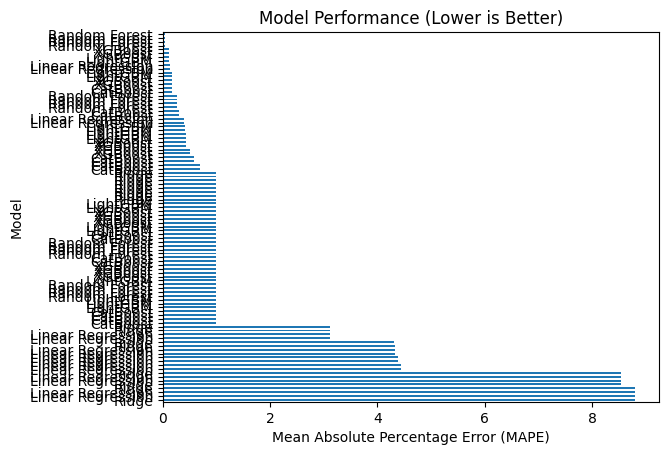

In [12]:
# Visualize results
def plot_results(results_df):
    plt.figure(figsize=(12, 6))
    results_df.sort_values('MAPE', ascending=True).plot.barh(x='Model', y='MAPE', legend=False)
    plt.xlabel('Mean Absolute Percentage Error (MAPE)')
    plt.title('Model Performance (Lower is Better)')
    plt.gca().invert_yaxis()
    plt.show()

plot_results(results_df)

In [13]:
results_df

,Model,Imputation,Encoding,Scaling,Log_Transform,MAPE,Submission_File
0,Linear Regression,mean,label,standard,True,4.388320,submission_Linear Regression_mean_label_standa...
1,Ridge,mean,label,standard,True,0.995936,submission_Ridge_mean_label_standard_True.csv
2,Random Forest,mean,label,standard,True,0.999251,submission_Random Forest_mean_label_standard_T...
3,XGBoost,mean,label,standard,True,0.999250,submission_XGBoost_mean_label_standard_True.csv
4,LightGBM,mean,label,standard,True,0.999251,submission_LightGBM_mean_label_standard_True.csv
...,...,...,...,...,...,...,...
91,Ridge,None,onehot,minmax,False,4.300793,submission_Ridge_None_onehot_minmax_False.csv
92,Random Forest,None,onehot,minmax,False,0.051886,submission_Random Forest_None_onehot_minmax_Fa...
93,XGBoost,None,onehot,minmax,False,0.123099,submission_XGBoost_None_onehot_minmax_False.csv
94,LightGBM,None,onehot,minmax,False,0.127090,submission_LightGBM_None_onehot_minmax_False.csv


In [14]:
sorted_results_df = results_df.sort_values(by="MAPE", ascending=True)
sorted_results_df

,Model,Imputation,Encoding,Scaling,Log_Transform,MAPE,Submission_File
56,Random Forest,None,label,standard,False,0.051803,submission_Random Forest_None_label_standard_F...
80,Random Forest,None,onehot,standard,False,0.051824,submission_Random Forest_None_onehot_standard_...
68,Random Forest,None,label,minmax,False,0.051852,submission_Random Forest_None_label_minmax_Fal...
92,Random Forest,None,onehot,minmax,False,0.051886,submission_Random Forest_None_onehot_minmax_Fa...
93,XGBoost,None,onehot,minmax,False,0.123099,submission_XGBoost_None_onehot_minmax_False.csv
...,...,...,...,...,...,...,...
7,Ridge,mean,label,standard,False,8.526476,submission_Ridge_mean_label_standard_False.csv
67,Ridge,None,label,minmax,False,8.796206,submission_Ridge_None_label_minmax_False.csv
66,Linear Regression,None,label,minmax,False,8.796227,submission_Linear Regression_None_label_minmax...
54,Linear Regression,None,label,standard,False,8.796227,submission_Linear Regression_None_label_standa...


In [15]:
sorted_results_df.head(10)

,Model,Imputation,Encoding,Scaling,Log_Transform,MAPE,Submission_File
56,Random Forest,None,label,standard,False,0.051803,submission_Random Forest_None_label_standard_F...
80,Random Forest,None,onehot,standard,False,0.051824,submission_Random Forest_None_onehot_standard_...
68,Random Forest,None,label,minmax,False,0.051852,submission_Random Forest_None_label_minmax_Fal...
92,Random Forest,None,onehot,minmax,False,0.051886,submission_Random Forest_None_onehot_minmax_Fa...
93,XGBoost,None,onehot,minmax,False,0.123099,submission_XGBoost_None_onehot_minmax_False.csv
81,XGBoost,None,onehot,standard,False,0.123099,submission_XGBoost_None_onehot_standard_False.csv
94,LightGBM,None,onehot,minmax,False,0.127090,submission_LightGBM_None_onehot_minmax_False.csv
82,LightGBM,None,onehot,standard,False,0.127090,submission_LightGBM_None_onehot_standard_False...
72,Linear Regression,None,onehot,standard,True,0.129161,submission_Linear Regression_None_onehot_stand...
84,Linear Regression,None,onehot,minmax,True,0.129184,submission_Linear Regression_None_onehot_minma...


In [17]:
# Get the file names of the first 10 models
top_10_files = sorted_results_df.head(10)['Submission_File'].tolist()

# Initialize an array to hold the predictions
predictions_list = []

# Read the predictions from the top 10 submission files
for file in top_10_files:
    submission_df = pd.read_csv(file)
    predictions_list.append(submission_df['num_sold'].values)

# Calculate the average predictions
average_predictions = np.mean(predictions_list, axis=0)

# Create a new submission DataFrame
submission_template['num_sold'] = average_predictions

# Save the averaged submission to a new CSV file
submission_template.to_csv("submission_average_top10.csv", index=False)

In [18]:
submission_template

,id,num_sold
0,230130,145.421683
1,230131,798.920386
2,230132,724.463547
3,230133,377.890274
4,230134,433.632240
...,...,...
98545,328675,357.517407
98546,328676,2267.667925
98547,328677,1837.195964
98548,328678,1024.269644
